In [2]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
import random
import matplotlib.pyplot as plt

In [3]:
im_shape = (250,250)

TRAINING_DIR = 'data/train'
TEST_DIR = 'data/test'

seed = 10

BATCH_SIZE = 16

In [4]:
data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)
val_data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [5]:
train_generator = data_generator.flow_from_directory(TRAINING_DIR, target_size=im_shape, shuffle=True, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="training")

validation_generator = val_data_generator.flow_from_directory(TRAINING_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="validation")


test_generator = ImageDataGenerator(rescale=1./255)
test_generator = test_generator.flow_from_directory(TEST_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE)

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)

Found 20534 images belonging to 20 classes.
Found 5123 images belonging to 20 classes.
Found 7070 images belonging to 20 classes.
Classes: ['Apple', 'Avocado', 'Banana', 'Blackberry', 'Blueberry', 'Dates', 'Dragonfruit', 'Fig', 'Grapes', 'Guava', 'Kiwi', 'Lemon', 'Mango', 'Orange', 'Pear', 'Pineapple', 'Pomegranate', 'Rambutan', 'Strawberry', 'Watermelon']


In [6]:
model = Sequential()
model.add(Conv2D(20, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(im_shape[0],im_shape[1],3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(40, kernel_size=(3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])



C:\Users\yousi\PycharmProjects\fruit-detection\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 248, 248, 20)   │           560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 124, 124, 20)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 122, 122, 40)   │         7,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 595360)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │    59,536,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │         2,020 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,545,920 (227.15 MB)

 Trainable params: 59,545,920 (227.15 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
epochs = 1

#Callback to save the best model
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='models/model.h5',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,verbose=1)
]

#Training
history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // BATCH_SIZE,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=validation_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // BATCH_SIZE)

 797/1283 ━━━━━━━━━━━━━━━━━━━━ 5:17 653ms/step - accuracy: 0.1572 - loss: 5.2142

C:\Users\yousi\PycharmProjects\fruit-detection\.venv\lib\site-packages\PIL\Image.py:1034: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1283/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 654ms/step - accuracy: 0.1972 - loss: 4.2804
Epoch 1: val_loss improved from None to 1.95640, saving model to model.h5


1283/1283 ━━━━━━━━━━━━━━━━━━━━ 864s 673ms/step - accuracy: 0.2925 - loss: 2.5845 - val_accuracy: 0.4025 - val_loss: 1.9564


In [8]:
# Load the best saved model
from tensorflow.keras.models import load_model

model = load_model('models/model.h5')

In [10]:
# Using the validation dataset
score = model.evaluate(validation_generator)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

321/321 ━━━━━━━━━━━━━━━━━━━━ 29s 88ms/step - accuracy: 0.4027 - loss: 1.9560
Val loss: 1.9560203552246094
Val accuracy: 0.4026937484741211


In [11]:

score = model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])



442/442 ━━━━━━━━━━━━━━━━━━━━ 35s 79ms/step - accuracy: 0.4199 - loss: 1.8929
Test loss: 1.8929195404052734
Test accuracy: 0.4199434220790863


442/442 ━━━━━━━━━━━━━━━━━━━━ 36s 80ms/step


Text(0.5, 1.0, 'Confusion Matrix')

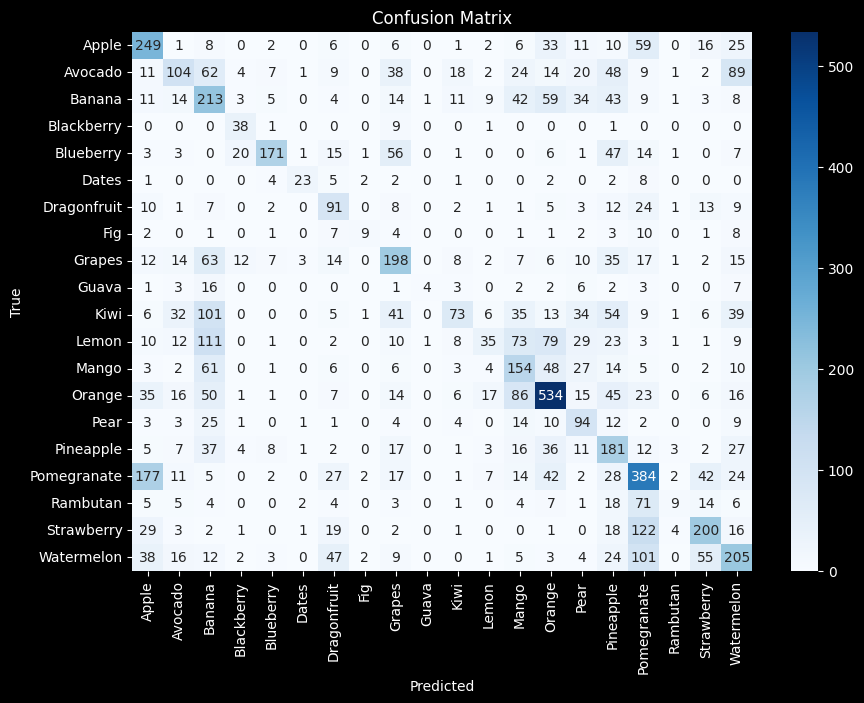

In [14]:
# Some reports
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

#Confusion matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

In [15]:
#Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))


Classification Report
              precision    recall  f1-score   support

       Apple       0.41      0.57      0.48       435
     Avocado       0.42      0.22      0.29       463
      Banana       0.27      0.44      0.34       484
  Blackberry       0.44      0.76      0.56        50
   Blueberry       0.79      0.49      0.61       347
       Dates       0.70      0.46      0.55        50
 Dragonfruit       0.34      0.48      0.39       190
         Fig       0.53      0.18      0.27        50
      Grapes       0.43      0.46      0.45       426
       Guava       0.67      0.08      0.14        50
        Kiwi       0.51      0.16      0.24       456
       Lemon       0.39      0.09      0.14       408
       Mango       0.32      0.45      0.37       346
      Orange       0.59      0.61      0.60       872
        Pear       0.31      0.51      0.39       183
   Pineapple       0.29      0.49      0.36       373
 Pomegranate       0.43      0.49      0.46       787
    R